In [2]:
import os, sys
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # Para no tener problemas de relative imports with packages
from utils import util

In [3]:
# Functions
def load_raw_audios(dataframe, source, dest_root, split_name):
    '''Copies dataframe-selected audio files from source to dest_root/split_name/'''
    dest = os.path.join(dest_root, split_name)
    os.makedirs(dest, exist_ok=True)

    for _, row in dataframe.iterrows():
        primary_label = row['primary_label']
        filename = row['filename']
        
        source_path = os.path.join(source, primary_label, filename)
        destination_path = os.path.join(dest, filename)

        if os.path.exists(source_path):
            shutil.copy2(source_path, destination_path)

In [4]:
# Paths
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final_species.csv')) 
birdclef_dir = os.path.join('..', 'data', 'birdclef-2021', 'train_short_audio')
audio_dir = os.path.join('..', 'database', 'audio')

In [5]:
def try_split_with_seed(df, test_size, seed, min_test_segments, target_test_segments):
    """
    Try a single split with a given seed and evaluate its quality.
    
    Parameters:
    - df: DataFrame with 'class_id', 'author', and 'usable_segments' columns
    - test_size: Target test set size (0.0 to 1.0)
    - seed: Random seed for the split
    - min_test_segments: Minimum total segments per class in test set
    - target_test_segments: Target segments per class for test set
    - total_segments_per_class: Total segments per class in the dataset
    
    Returns:
    - (dev_df, test_df, score) if split is valid, None otherwise
    """
    try:
        gss = GroupShuffleSplit(
            n_splits=1, 
            test_size=test_size,
            random_state=seed
        )

        dev_indices, test_indices = next(gss.split(
            X=df, 
            y=df['class_id'], 
            groups=df['author']
        ))

        dev_df = df.iloc[dev_indices]
        test_df = df.iloc[test_indices]
        
        # Check if all classes are in both sets
        dev_classes = set(dev_df['class_id'])
        test_classes = set(test_df['class_id'])
        all_classes = set(df['class_id'])
        
        if not (all_classes <= dev_classes and all_classes <= test_classes):
            return None  # Skip if missing classes in either set
        
        # Check that each class in dev has at least 2 authors
        dev_authors_per_class = dev_df.groupby('class_id')['author'].nunique()
        if dev_authors_per_class.min() < 2:
            return None  # Skip if any class has fewer than 2 authors in dev
        
        # Check minimum test segments per class
        test_segments_per_class = test_df.groupby('class_id')['usable_segments'].sum()
        if test_segments_per_class.min() < min_test_segments:
            return None  # Skip if any class has too few test segments
        
        # Calculate stratification score based on segments (lower is better)
        actual_test_segments = test_df.groupby('class_id')['usable_segments'].sum().sort_index()
        
        # Mean absolute percentage error from target
        score = np.mean(np.abs(actual_test_segments.values - target_test_segments.values) / target_test_segments.values)
        
        return dev_df.copy(), test_df.copy(), score
    
    except Exception as e:
        return None

def group_split_with_stratification_search(df, test_size, max_attempts, min_test_segments):
    """
    Search for the best stratified split while maintaining author grouping.
    Based on total usable segments per class rather than sample counts.
    
    Parameters:
    - df: DataFrame with 'class_id', 'author', and 'usable_segments' columns
    - test_size: Target test set size (0.0 to 1.0)
    - max_attempts: Maximum number of random seeds to try
    - min_test_segments: Minimum total segments per class in test set
    
    Returns:
    - best_dev_df, best_test_df: Best split found
    - best_score: Stratification quality score
    """
    
    # Calculate target distribution based on total segments per class
    total_segments_per_class = df.groupby('class_id')['usable_segments'].sum().sort_index()
    target_test_segments = (total_segments_per_class * test_size).round().astype(int)
    
    best_score = float('inf')
    best_dev_df = None
    best_test_df = None
    best_seed = None
    
    for seed in range(max_attempts):
        result = try_split_with_seed(df, test_size, seed, min_test_segments, target_test_segments)
        
        if result is not None:
            dev_df, test_df, score = result
            
            if score < best_score:
                best_score = score
                best_dev_df = dev_df
                best_test_df = test_df
                best_seed = seed
                
                print(f"New best split found! Seed: {seed}, Score: {score:.3f}")
    
    if best_dev_df is None:
        if min_test_segments < 10:
            raise ValueError("No valid split found with current constraints. Consider relaxing min_test_segments.")
        return group_split_with_stratification_search(df, test_size, max_attempts, min_test_segments=10)
    
    print(f"\nBest split found:")
    print(f"Seed: {best_seed}")
    print(f"Stratification score: {best_score:.3f}")
    print(f"Author overlap: {set(best_dev_df['author']) & set(best_test_df['author'])}")

    print(f"Segments in dev set: {best_dev_df['usable_segments'].sum()}")
    print(f"Segments in test set: {best_test_df['usable_segments'].sum()}")
    print(f"Dev segment%: {best_dev_df['usable_segments'].sum() / df['usable_segments'].sum():.2%}")
    print(f"Test segment%: {best_test_df['usable_segments'].sum() / df['usable_segments'].sum():.2%}")

    # Print distribution comparison
    print("\nSegment distribution comparison:")
    actual_test_segments = best_test_df.groupby('class_id')['usable_segments'].sum().sort_index()
    dev_segments = best_dev_df.groupby('class_id')['usable_segments'].sum().sort_index()
    target_dev_segments = total_segments_per_class - target_test_segments
    
    comparison_df = pd.DataFrame({
        'Target_Test_Segments': target_test_segments,
        'Actual_Test_Segments': actual_test_segments,
        'Target_Dev_Segments': target_dev_segments,
        'Actual_Dev_Segments': dev_segments,
        'Total_Segments': total_segments_per_class
    })
    
    print(tabulate(comparison_df, headers=comparison_df.columns, tablefmt='grid'))
    
    return best_dev_df, best_test_df, best_score

This one to test stratified seeds

In [ ]:
# dev_df, test_df, score = group_split_with_stratification_search(df, test_size=0.2, max_attempts=2_500_000, min_test_segments=8)

This one to run with a good seed

In [6]:
test_size = 0.2
total_segments_per_class = df.groupby('class_id')['usable_segments'].sum().sort_index()
test_targets = (total_segments_per_class * test_size).round().astype(int)

dev_df, test_df, score = try_split_with_seed(df, test_size=test_size, seed=336680, min_test_segments=8, target_test_segments=test_targets)

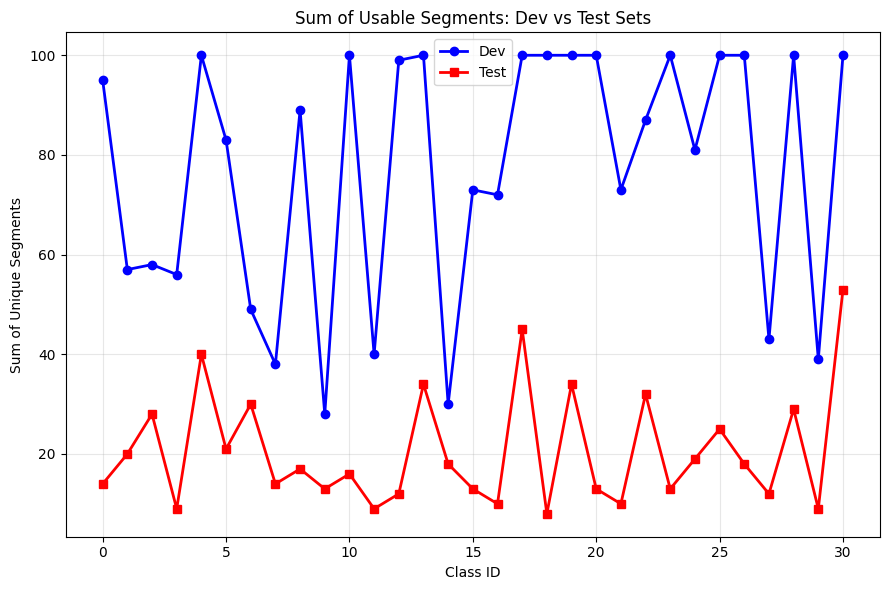

In [7]:
# Calculate sum of unique_segments for each class_id in dev and test sets
dev_segments = dev_df.groupby('class_id')['usable_segments'].sum().sort_index().clip(upper=100)
test_segments = test_df.groupby('class_id')['usable_segments'].sum().sort_index().clip(upper=100)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

# Plot as two separate lines
ax.plot(dev_segments.index, dev_segments.values, marker='o', linewidth=2, label='Dev', color='blue')
ax.plot(test_segments.index, test_segments.values, marker='s', linewidth=2, label='Test', color='red')

ax.set_title('Sum of Usable Segments: Dev vs Test Sets')
ax.set_xlabel('Class ID')
ax.set_ylabel('Sum of Unique Segments')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Print samples per class_id in dev and test sets using tabulate for fancy formatting
dev_samples = dev_df.groupby('class_id').size().sort_index()
test_samples = test_df.groupby('class_id').size().sort_index()

comparison_data = []
for class_id in dev_samples.index:
    comparison_data.append([
        class_id,
        dev_samples[class_id],
        test_samples[class_id],
        dev_samples[class_id] + test_samples[class_id]
    ])

print("Samples per class_id comparison:")
print(tabulate(comparison_data, 
                headers=['Class ID', 'Dev Samples', 'Test Samples', 'Total Samples'], 
                tablefmt='grid'))

Samples per class_id comparison:
+------------+---------------+----------------+-----------------+
|   Class ID |   Dev Samples |   Test Samples |   Total Samples |
+============+===============+================+=================+
|          0 |            10 |              4 |              14 |
+------------+---------------+----------------+-----------------+
|          1 |            11 |              4 |              15 |
+------------+---------------+----------------+-----------------+
|          2 |             6 |              4 |              10 |
+------------+---------------+----------------+-----------------+
|          3 |             8 |              2 |              10 |
+------------+---------------+----------------+-----------------+
|          4 |            32 |              9 |              41 |
+------------+---------------+----------------+-----------------+
|          5 |            16 |              4 |              20 |
+------------+---------------+-------------

In [9]:
# Main
util.clean_dir(audio_dir)

print("Loading Dev Files...")
load_raw_audios(dev_df, birdclef_dir, audio_dir, split_name='dev')

print("Loading Test Files...")
load_raw_audios(test_df, birdclef_dir, audio_dir, split_name='test')

Resetting ..\database\audio directory...
Loading Dev Files...
Loading Test Files...


In [10]:
# Check that dev_df and test_df do not share any samples with the same filename
dev_filenames = set(dev_df['filename'])
test_filenames = set(test_df['filename'])

overlap = dev_filenames & test_filenames

if overlap:
    print(f"WARNING: Found {len(overlap)} overlapping filenames between dev and test sets:")
    for filename in sorted(overlap):
        print(f"  - {filename}")
else:
    print("✓ No overlapping filenames between dev and test sets")

print(f"\nDev set: {len(dev_filenames)} unique filenames")
print(f"Test set: {len(test_filenames)} unique filenames")
print(f"Total unique filenames: {len(dev_filenames | test_filenames)}")

✓ No overlapping filenames between dev and test sets

Dev set: 541 unique filenames
Test set: 149 unique filenames
Total unique filenames: 690


In [12]:
# CSV with only dev species
dev_data_path = os.path.join('..', 'database', 'meta', 'dev_data.csv')
dev_df.to_csv(dev_data_path, index=False)

# CSV with only test species
test_data_path = os.path.join('..', 'database', 'meta', 'test_data.csv')
test_df.to_csv(test_data_path, index=False)